

> authored by Ena Macahiya



# Random Forest Overview
- supervised learning, handles regression and classification
- ensemble learning method - combine predictions from other models. each smaller model in random forest ensemble is a **decision tree**
- how it works: multiple trees are created using random subsets of data and features. each DT is an expert providing its opinion on how to classify the data. predictions are made by calculating prediction for each DT and returning most popular or average result

In [3]:
import pandas as pd
import math
import os

# model imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint

In [ ]:
# import preprocessed data
USE_AAPL = False  # set to false to run against entire s&p500 dataset

if USE_AAPL:
    path = "../../data/processed/processed_AAPL"
else:
    path = "../../data/processed/processed_all"
os.makedirs(path, exist_ok=True)

X_train = pd.read_csv(os.path.join(path, 'X_train.csv'))
X_test = pd.read_csv(os.path.join(path, 'X_test.csv'))
X_val = pd.read_csv(os.path.join(path, 'X_val.csv'))

y_train = pd.read_csv(os.path.join(path, 'y_train.csv')).iloc[:, 0]
y_test = pd.read_csv(os.path.join(path, 'y_test.csv')).iloc[:, 0]
y_val = pd.read_csv(os.path.join(path, 'y_val.csv')).iloc[:, 0]

In [5]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_train sample data:\n{y_train.head()}")

X_train shape: (749, 10)
y_train shape: (749,)
y_train sample data:
0    63.2571
1    64.1385
2    63.5099
3    63.0571
4    61.4957
Name: target, dtype: float64


In [ ]:
tscv = TimeSeriesSplit(n_splits=10)

# fit model w hyperparam tuning
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

rf = RandomForestRegressor(random_state=42) # params can use n_estimators and random_state to have same result

rand_search = RandomizedSearchCV(rf, # model
                                 param_distributions = param_dist, # dict of hyp ranges to sample from
                                 n_iter=5, # num of random combos
                                 cv=tscv, # num of folds in cross-validation
                                 random_state=42, # seed
                                 n_jobs=4, # 4 CPU cores
                                 verbose=2) # shows progress

rand_search.fit(X_train, y_train)

Fitting 15 folds for each of 5 candidates, totalling 75 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=15, test_size=None),
                   estimator=RandomForestRegressor(random_state=42), n_iter=5,
                   n_jobs=4,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000281F18DBC50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000281EF75A9C0>},
                   random_state=42, verbose=2)

In [19]:
# View CV scores of a basic RandomForest before tuning
cv_scores = cross_val_score(rf, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
print("Cross-Validation MSEs:", -cv_scores)
print("Average CV MSE:", -cv_scores.mean())

Cross-Validation MSEs: [ 0.82907903 23.35469682 21.02591033  2.331882    0.68757436 72.99362697
 21.10096251  6.30643935 37.01863098 64.08494204  3.91444965  4.01984019
 10.3256281   4.49153498  5.60028622]
Average CV MSE: 18.539032234569213


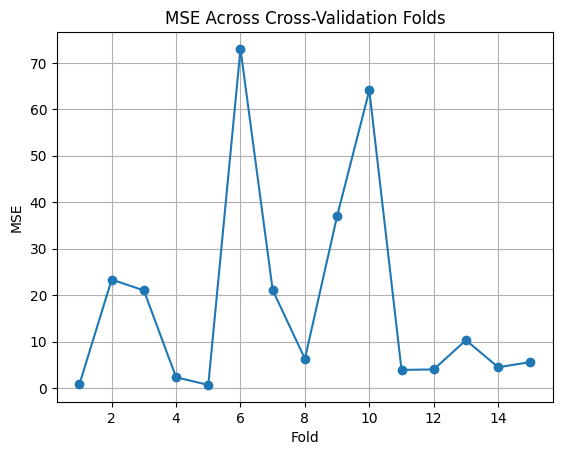

In [20]:
import matplotlib.pyplot as plt

mse_scores = [-score for score in cv_scores]  # convert to positive
plt.plot(range(1, len(mse_scores)+1), mse_scores, marker='o')
plt.title("MSE Across Cross-Validation Folds")
plt.xlabel("Fold")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

In [21]:
# best model from random hyp test
best_rf = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 7, 'n_estimators': 171}


In [22]:
# val predictions and acc
y_pred = best_rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print("MSE:", mse)
print("Root Mean Squared Error:", math.sqrt(mse))
print("R²:", r2_score(y_val, y_pred))

MSE: 2.988185073322651
Root Mean Squared Error: 1.7286367673177183
R²: 0.9628814650732183


In [24]:
# test predictions and acc
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
print("Root Mean Squared Error:", math.sqrt(mse))
print("R²:", r2_score(y_test, y_pred))

MSE: 877.0794298293781
Root Mean Squared Error: 29.61552683693772
R²: -4.936973615526865


# Rundown of Accuracy Calculations
MSE = the closer to zero, the better. lower = better fit of the model to the data. measures the avg of the squares of the errors or deviations. for each data point find this: (actual value - predicted value)^2 and add it all together. then divide by the number of data points. </br>
R^2 = the higher, the better. if its 1, the model explains all the variability of the dependent variable around its mean. represents the proportion of the variance in the dependent variable that can be explained by the independent variables in a regression model. (how well does the independent var explain the variability of the dependent varaible). the formula is a little more complicated but in essence you divide the sum of squares of residuals over the total sum of squares, and subtract it from 1.

# Saving the Model

In [42]:
import joblib
import os 

model_dir = 'D:\\AI4ALL-Group-8C\\models'
model_filename = '2_random_forest_regressor.joblib'
model_path = os.path.join(model_dir, model_filename)

os.makedirs(model_dir, exist_ok=True)

# save the model
joblib.dump(best_rf, model_path)
print(f"model saved to {model_path}")

model saved to D:\AI4ALL-Group-8C\models\2_random_forest_regressor.joblib


In [ ]:
# model loading (for use in a new session or after training is done)
# to load the model, uncomment if running the full notebook without re-training.

# loaded_model = joblib.load(model_path)
# print("model loaded successfully!")

# # example: Test predictions and accuracy using the loaded model
# y_pred_loaded_test = loaded_model.predict(X_test)
# print("\nMetrics from Loaded Model (Test Set)")
# print("MSE (Test):", mean_squared_error(y_test, y_pred_loaded_test))
# print("R² (Test):", r2_score(y_test, y_pred_loaded_test))